<a href="https://colab.research.google.com/github/lsteffenel/ED-SNI-IntroDL/blob/main/03_Classification_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction à la classification : des images de vêtements

Ce guide forme un modèle de réseau neuronal pour classer les images de vêtements, comme les baskets et les chemises. Ce n'est pas grave si vous ne comprenez pas tous les détails; il s'agit d'un aperçu rapide d'un programme TensorFlow complet avec les détails expliqués au fur et à mesure.

Ce guide utilise [keras](https://keras.io/), une API de haut niveau pour créer et former des modèles dans TensorFlow (ou pytorch, si vous selectionnez l'autre option). En effet, c'est très transparent, vous n'aurez aucune ligne supplémentaire à changer, sauf si vous voulez des fonctionnalités spécifiques de chacun des frameworks.

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["KERAS_BACKEND"] = "torch"

import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

print(keras.__version__)


3.8.0


## Importer le dataset Fashion MNIST

 Ce guide utilise le jeu de données [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) qui contient 70 000 images en niveaux de gris dans 10 catégories. Les images montrent des vêtements individuels à basse résolution (28 par 28 pixels), comme on le voit ici :

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST est conçu pour remplacer l'ensemble de données [MNIST](http://yann.lecun.com/exdb/mnist/) classique, souvent utilisé comme "Hello, World" des programmes d'apprentissage automatique pour la vision par ordinateur. Le jeu de données MNIST contient des images de chiffres manuscrits (0, 1, 2, etc.) dans un format identique à celui des vêtements que vous utiliserez ici.

Ce guide utilise Fashion MNIST pour la variété et parce que c'est un problème légèrement plus difficile que le MNIST ordinaire. Les deux ensembles de données sont relativement petits et sont utilisés pour vérifier qu'un algorithme fonctionne comme prévu. Ce sont de bons points de départ pour tester et déboguer le code.

Ici, 60 000 images sont utilisées pour former le réseau et 10 000 images pour évaluer la précision avec laquelle le réseau a appris à classer les images. Vous pouvez accéder au Fashion MNIST directement depuis TensorFlow. Importez et chargez les données [Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directement depuis TensorFlow :

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Le chargement de l'ensemble de données renvoie quatre tableaux NumPy :

* Les tableaux `train_images` et `train_labels` sont l'*ensemble d'apprentissage* - les données que le modèle utilise pour apprendre.
* Le modèle est testé par rapport à l'*ensemble de tests*, aux tableaux `test_images` et `test_labels`.

Les images sont des tableaux NumPy 28x28, avec des valeurs de pixels allant de 0 à 255. Les *étiquettes* sont un tableau d'entiers, allant de 0 à 9. Ceux-ci correspondent à la *classe* de vêtements que l'image représente :


<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Chaque image est associée à une seule étiquette. Étant donné que les *noms de classe* ne sont pas inclus dans le jeu de données, stockez-les ici pour les utiliser ultérieurement lors du traçage des images :


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Explorer les données

Explorons le format de l'ensemble de données avant de former le modèle. L'exemple suivant montre qu'il y a 60 000 images dans l'ensemble d'apprentissage, chaque image étant représentée en 28 x 28 pixels :

In [ ]:
train_images.shape

(60000, 28, 28)

De même, il y a 60 000 libellés dans l'ensemble d'apprentissage :

In [ ]:
len(train_labels)

60000

Chaque étiquette est un entier compris entre 0 et 9 :

In [ ]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

Il y a 10 000 images dans le jeu de test. Encore une fois, chaque image est représentée en 28 x 28 pixels :

In [ ]:
test_images.shape

(10000, 28, 28)

Et le jeu de test contient 10 000 étiquettes d'images :

In [ ]:
len(test_labels)

10000

## Prétraiter les données

Les données doivent être prétraitées avant de former le réseau. Si vous inspectez la première image de l'ensemble d'apprentissage, vous verrez que les valeurs de pixel se situent dans la plage de 0 à 255 :

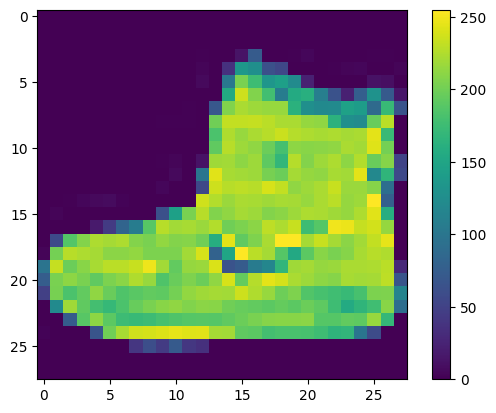

In [ ]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Mettez ces valeurs à l'échelle dans une plage de 0 à 1 avant de les alimenter au modèle de réseau neuronal. Pour ce faire, divisez les valeurs par 255. Il est important que l'*ensemble d'apprentissage* et l'*ensemble de test* soient prétraités de la même manière :

In [ ]:
train_images = train_images / 255.0

test_images = test_images / 255.0

Pour vérifier que les données sont au format correct et que vous êtes prêt à construire et former le réseau, affichons les 25 premières images de l'*ensemble d'entraînement* et affichons le nom de la classe sous chaque image.

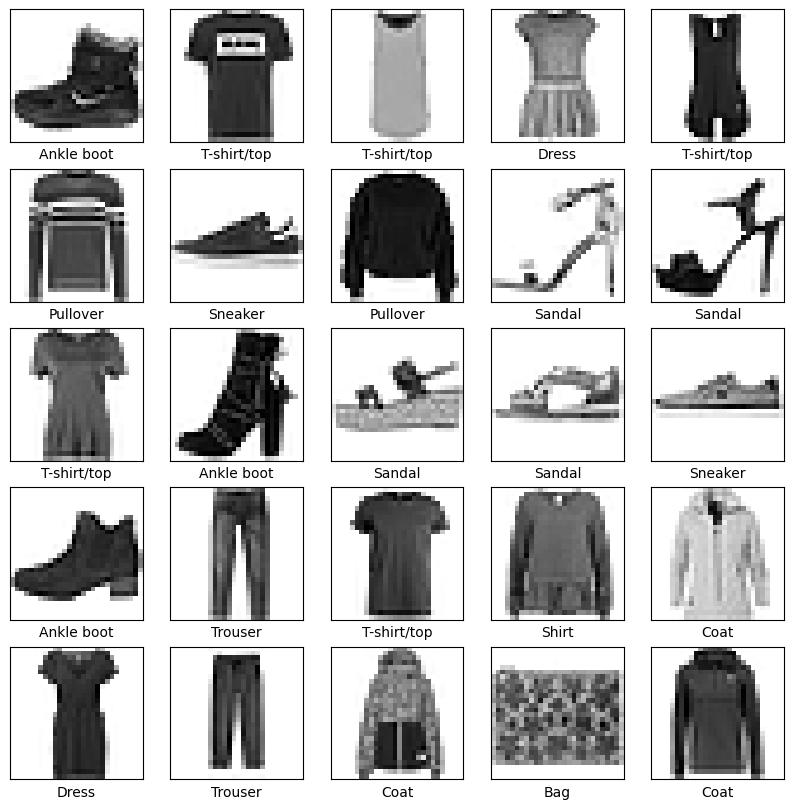

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Un premier modèle avec un réseau Dense (DNN)

Dans cette première étape, nous allons construire le réseau de neurones avec un modèle dense (DNN).

### Mettre en place des couches

Le bloc de construction de base d'un réseau de neurones est la [*couche*](https://keras.io/api/layers/). Les couches extraient des représentations des données qui y sont introduites. Espérons que ces représentations sont significatives pour le problème à résoudre.

L'essentiel de l'apprentissage en profondeur consiste à enchaîner des couches simples. La plupart des couches, telles que `keras.layers.Dense`, ont des paramètres appris lors de la formation.

In [ ]:
from keras import layers
from keras import optimizers

model = keras.Sequential()
model.add(layers.Input((28,28)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10))

La première couche de ce réseau, `keras.layers.Flatten`, transforme le format des images d'un tableau bidimensionnel (de 28 par 28 pixels) en un tableau unidimensionnel (de 28 * 28 = 784 pixels). Considérez ce calque comme si on désempillait les rangées de pixels et les alignait. Cette couche n'a aucun paramètre à apprendre, elle ne fait que reformater les données.

Une fois les pixels aplatis, le réseau rajoute deux couches `keras.layers.Dense`. Ce sont des couches neuronales densément connectées (ou totalement connectées). La première couche `Dense` compte 128 nœuds (ou neurones). La deuxième (et dernière) couche renvoie un tableau logits d'une longueur de 10. Chaque nœud contient un score indiquant que l'image actuelle appartient à l'une des 10 classes.

Nous appelons ce modèle **dense** car tous les neurones d'une couche sont connectés à la sortie de tous les neurones de la couche précédente. Ainsi, par exemple, le premier neurone de la couche de sortie reçoit les informations de tous les 128 neurones de la couche intermédiaire. Ce type de réseau peut présenter des limitations tant en performance qu'en généralisation.


### Compiler le modèle

Avant que le modèle ne soit prêt pour l'entraînement, il a besoin de quelques réglages supplémentaires. Ceux-ci sont ajoutés lors de l'étape de compilation du modèle :

* [*Fonction de perte*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) : mesure la précision du modèle pendant l'entraînement. Vous souhaitez minimiser cette fonction pour "orienter" le modèle dans la bonne direction.
*[*Optimiseur*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) : c'est ainsi que le modèle est mis à jour en fonction des données qu'il voit et de sa fonction de perte.
*[*Métriques*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)  : utilisées pour surveiller les étapes de formation et de test. L'exemple suivant utilise l'*accuracy*, la fraction des images qui sont correctement classées.


In [ ]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Entraîner le modèle

L'entraînement du modèle de réseau neuronal nécessite les étapes suivantes :

1. Transférez les données de formation au modèle. Dans cet exemple, les données d'apprentissage se trouvent dans les tableaux `train_images` et `train_labels`.
2. Le modèle apprend à associer des images et des étiquettes.
3. Vous demandez au modèle de faire des prédictions sur un jeu de test — dans cet exemple, le tableau `test_images`.
4. Vérifiez que les prédictions correspondent aux étiquettes du tableau `test_labels`.


### 1. Alimenter le modèle avec des données

Pour commencer l'entraînement, appelez la méthode [`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit), ainsi appelée car elle "adapte" le modèle aux données d'entraînement. Nous avons indiqué au modèle de repasser 10x sur l'ensemble de données (on apprend toujours plus si on revise plusieurs fois).

In [ ]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7822 - loss: 0.6219
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8631 - loss: 0.3804
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8765 - loss: 0.3361
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8847 - loss: 0.3126
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8911 - loss: 0.2942
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8972 - loss: 0.2783
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9003 - loss: 0.2665
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9033 - loss: 0.2575
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9067 - loss: 0.2480
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9096 - loss: 0.2416


Au fur et à mesure que le modèle s'entraîne, les métriques de perte et de précision sont affichées. Ce modèle atteint une accuracy d'environ 0,91 (ou 91%) sur les données d'apprentissage.

### Évaluer l'accuracy

Ensuite, comparez les performances du modèle sur l'ensemble de données de test :

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - 4ms/step - accuracy: 0.8809 - loss: 0.3352

Test accuracy: 0.8809000253677368


Il s'avère que l'accuracy sur l'ensemble de données de test est un peu inférieure à l'accuracy sur l'ensemble de données d'apprentissage.

Cet écart entre la précision de l'entraînement et la précision des tests peut s'expliquer par un *surapprentissage*. Le surapprentissage se produit lorsqu'un modèle d'apprentissage automatique fonctionne moins bien sur de nouvelles entrées inédites que sur les données d'apprentissage. Un modèle surajusté "mémorise" le bruit et les détails dans l'ensemble de données d'apprentissage à un point tel qu'il a un impact négatif sur les performances du modèle sur les nouvelles données. Pour plus d'informations, consultez les éléments suivants :
*   [Démonstration d'overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#demonstrate_overfitting)
*   [Stratégies pour éviter l'overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting)

### Faire des prédictions
Avec le modèle formé, vous pouvez l'utiliser pour faire des prédictions sur certaines images. Attachez une couche softmax pour convertir les sorties linéaires du modèle ([logits](https://developers.google.com/machine-learning/glossary#logits)) en probabilités, ce qui devrait être plus facile à interpréter.

In [ ]:
probability_model = keras.Sequential([model,
                                         keras.layers.Softmax()])

In [ ]:
predictions = probability_model.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Ici, le modèle a prédit l'étiquette pour chaque image de l'ensemble de test. Affichons la prédiction pour la première image :

In [ ]:
predictions[0]

array([8.8538940e-07, 1.3456186e-07, 2.5168836e-10, 1.8383138e-10,
       4.3628696e-09, 3.5574256e-05, 5.7885373e-08, 1.9837782e-02,
       7.1603716e-07, 9.8012483e-01], dtype=float32)

Une prédiction est un tableau de 10 nombres. Ils représentent la "confiance" du modèle que l'image correspond à chacun des 10 vêtements différents. Vous pouvez voir quelle étiquette a la valeur de confiance la plus élevée :

In [ ]:
np.argmax(predictions[0])

np.int64(9)

Ainsi, le modèle est plus sûr que cette image est une bottine, ou `class_names[9]`. L'examen de l'étiquette du test montre que cette classification est correcte :

In [ ]:
test_labels[0]

np.uint8(9)

Représentez-le graphiquement pour examiner l'ensemble complet des 10 prédictions de classe.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Vérifier les prédictions
Avec le modèle formé, vous pouvez l'utiliser pour faire des prédictions sur certaines images.


Regardons l'image 0, les prédictions et le tableau de prédiction. Les étiquettes de prédiction correctes sont bleues et les étiquettes de prédiction incorrectes sont rouges. Le nombre donne le pourcentage (sur 100) pour l'étiquette prédite.

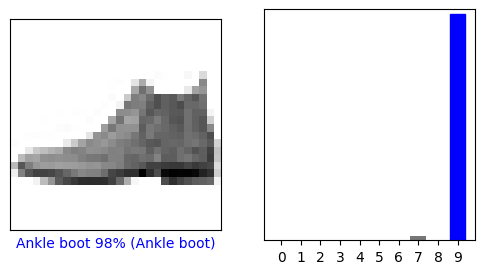

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

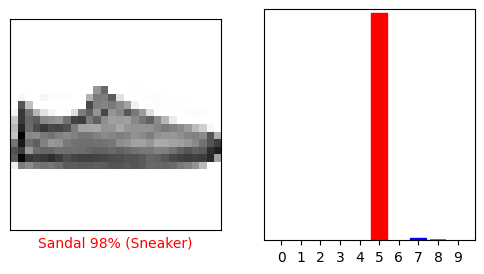

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Affichons plusieurs images avec leurs prédictions. Notez que le modèle peut se tromper même lorsqu'il est très confiant.

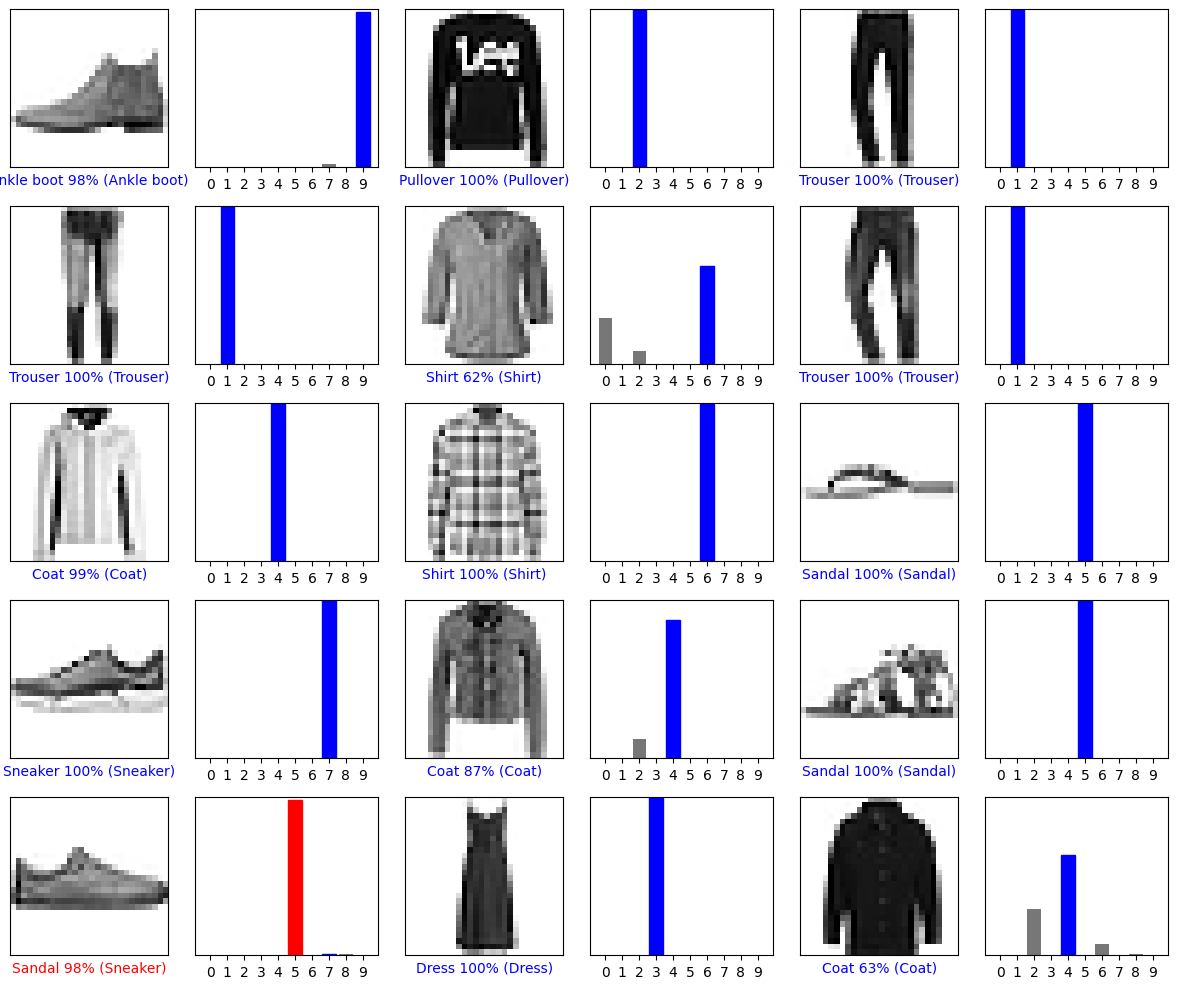

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Utiliser le modèle entraîné
Enfin, utilisez le modèle entraîné pour faire une prédiction sur une seule image.

In [ ]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)


(28, 28)


Les modèles `keras` sont optimisés pour effectuer des prédictions sur un *lot* (batch) ou une collection d'exemples à la fois. Par conséquent, même si vous utilisez une seule image, vous devez l'ajouter à une liste :

In [ ]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


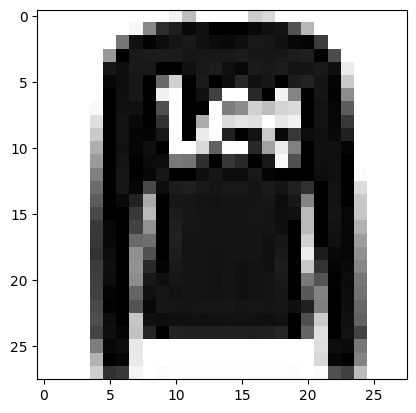

In [ ]:
plt.imshow(img[0], cmap=plt.cm.binary)

Prédisez maintenant le bon libellé pour cette image :

In [ ]:
predictions_single = probability_model.predict(img)

print(predictions_single)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
[[3.0472172e-06 9.1092715e-12 9.9849021e-01 1.1112552e-10 1.4045716e-03
  3.1036688e-12 1.0211008e-04 5.0091125e-12 8.0462330e-09 6.9856756e-13]]


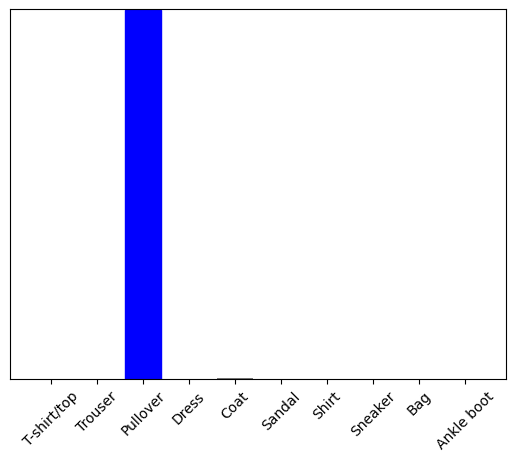

In [ ]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

`keras.Model.predict` renvoie une liste de listes, une liste pour chaque image du lot de données. Saisissez les prédictions pour notre (seule) image dans le lot :

In [ ]:
np.argmax(predictions_single[0])

np.int64(2)

Et le modèle prédit une étiquette comme prévu.

# Création d'un modèle avec un réseau convolutionnel (CNN)

Comme nous avons vu précédemment, le réseau présenté ci-dessus est de type **dense**, c'est-à-dire, chaque neurone d'une couche est connecté à la sortie de tous les neurones de la couche précédente.

Ce type de construction peut avoir des problèmes de performance si le nombre de neurones/pixels est trop important. De plus, on *fige* les poids sur des parties spécifiques de l'image, ce qui peut gêner la classification si l'image comporte de variations.

Dans cette section nous allons faire usage de couches de convolution et de pooling afin d'alléger le modèle et le rendre plus flexible.

Pour ce nouveau modèle, on utiliser les éléments suivants :

* **convolutions** `keras.layers.Conv2D` et `MaxPooling2D` - Le réseau commence par deux paires de Conv/MaxPool. La première couche est une convolution Conv2D avec des filtres (3,3) appliqués à l'image d'entrée. Elle  conserve la taille d'image d'origine en utilisant le remplissage (padding), et crée 32 images de sortie (convoluées) (cette couche crée donc 32 images convoluées de la même taille que l'entrée).
Ensuite, les 32 sorties sont réduites de taille en utilisant un MaxPooling2D (2,2) avec un décalage de 2. La couche Conv2D suivante a également un noyau (3,3). Elle prend les 32 images en entrée et crée 64 sorties qui sont à nouveau réduites de taille par une couche MaxPooling2D.

* **sortie** `keras.layers.Dense` - C'est une couche de 128 neurones suivie d'une couche **softmax** à 10 nœuds. Chaque nœud représente une classe de vêtement. La couche finale prend en entrée les 128 nœuds de la couche précédente et produit une valeur dans la plage [0, 1], représentant la probabilité que l'image appartienne à cette classe. La somme de toutes les valeurs des 10 nœuds est égale à 1.

In [ ]:
model2 = keras.Sequential()
model2.add(layers.Input((28,28,1))) # pas de flatten car on veut appliquer des convolutions 3x3 (2D)
model2.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model2.add(layers.MaxPooling2D((2, 2), strides=2)) # le MaxPooling sert juste à "compresser" l'information
model2.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model2.add(layers.MaxPooling2D((2, 2), strides=2))
model2.add(layers.Flatten()) # ici on fait Flatten sur l'image "filtrée" par les convolutions
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(10, activation='softmax'))


Comme précédemment, nous allons *compiler* le modèle en définissant certains paramètres (optimisateur, etc.). Notez qu'on a retiré l'option `(from_logits=True)` car la couche *softmax* est présente cette fois-ci.



In [ ]:
model2.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model2.fit(train_images, train_labels, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7998 - loss: 0.5576
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9015 - loss: 0.2692
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9203 - loss: 0.2174
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9322 - loss: 0.1807
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9411 - loss: 0.1581
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9485 - loss: 0.1322
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9601 - loss: 0.1066
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9673 - loss: 0.0928
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9718 - loss: 0.0731
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9781 - loss: 0.0601


À mesure que le modèle est entraîne, la perte et l'accuracy sont affichés. Ce modèle atteigne une accuracy autour de 0.97 (ou 97%) sur le dataset d'entraînement.

### Évaluer l'accuracy

Ensuite, comparez les performances du modèle sur l'ensemble de données de test :

In [ ]:
test_loss, test_acc = model2.evaluate(test_images, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 2s - 6ms/step - accuracy: 0.9170 - loss: 0.3304

Test accuracy: 0.9169999957084656


Même s'il y a une perte par rapport à l'ensemble d'entraînement, ce modèle atteigne plus de 91% d'accuracy sur l'ensemble de test (environ 87% avec le modèle DNN).

## Effectuer des prédictions et explorer les résultats
Avec le modèle entraîné, nous pouvons faire des predictions avec des nouvelles images.

In [ ]:
predictions = model2.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
predictions.shape

(10000, 10)

Ici, le modèle a prédit la probabilité de chaque étiquette pour chaque image de l'ensemble de tests. Jetons un coup d'œil à la première prédiction :

In [ ]:
predictions[0]

array([7.8431235e-09, 7.7805183e-08, 2.0671308e-10, 9.9159396e-13,
       2.2947974e-13, 3.5407129e-07, 1.4421485e-14, 5.7433692e-07,
       1.0467490e-12, 9.9999893e-01], dtype=float32)

Une prédiction est un tableau de 10 nombres. Ils décrivent la "confiance" du modèle que l'image correspond à chacun des 10 différents articles vestimentaires. Nous pouvons voir quelle étiquette a la valeur de confiance la plus élevée :

In [ ]:
np.argmax(predictions[0])

np.int64(9)

Le modèle est généralement le plus confiant que cette image est une chemise, ou `class_names[6]`. Vérifions l'étiquette :

In [ ]:
test_labels[0]

np.uint8(9)

Nous pouvons afficher l'ensemble des predictions pour les 10 classes

In [ ]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Regardons les images 0 et 12, avec leur prédiction et array de probabilités.

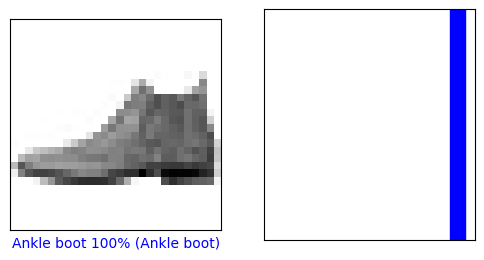

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

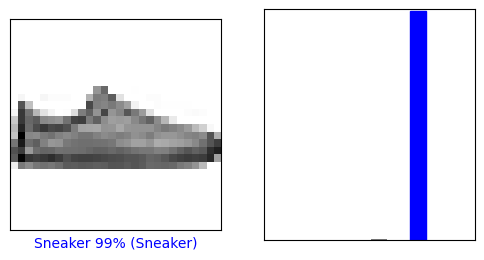

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Tiens, il a reconnu correctement les sneakers (sur le modèle DNN simple, on avait classé comme sandal)

Affichons plusieurs images avec leurs prédictions. Les étiquettes de prédiction correctes sont en bleu et les étiquettes de prédiction incorrectes sont en rouge. Le nombre indique le pourcentage (sur 100) pour l'étiquette prédite. Notez qu'il peut y avoir des erreurs même lorsque la confiance est très élevée.

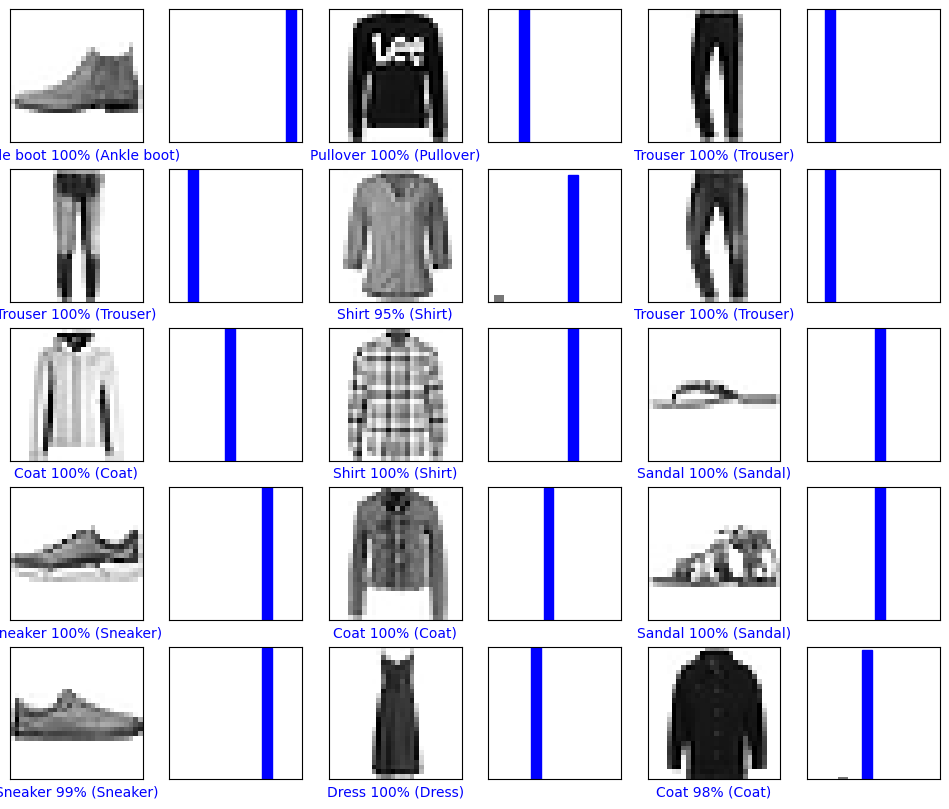

In [ ]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

## Utiliser le modèle entraîné
Enfin, utilisez le modèle entraîné pour faire une prédiction sur une seule image.

(28, 28)


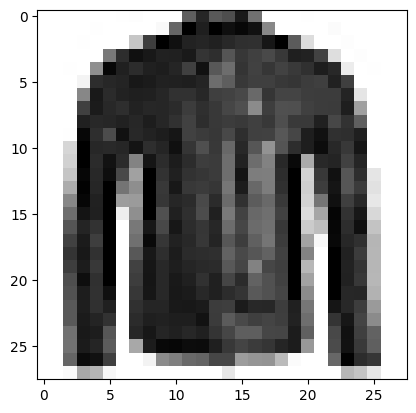

In [ ]:
# Grab an image from the test dataset.
img = test_images[50]
label_single = (test_labels[50],0) # Comme on n'a qu'une valeur, on la met en forme de tuple

print(img.shape)

plt.imshow(img, cmap=plt.cm.binary)



Les modèles `keras` sont optimisés pour effectuer des prédictions sur un *lot* (batch) ou une collection d'exemples à la fois. Par conséquent, même si vous utilisez une seule image, vous devez l'ajouter à une liste :

In [ ]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28)


Prédisez maintenant le bon libellé pour cette image :

In [ ]:
predictions_single = model2.predict(img)
print(predictions_single)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[1.3528536e-07 1.1798059e-08 3.4792139e-04 1.3192399e-08 9.6801603e-01
  2.6826792e-09 3.1635210e-02 1.3574097e-08 3.9911868e-08 7.0907379e-07]]


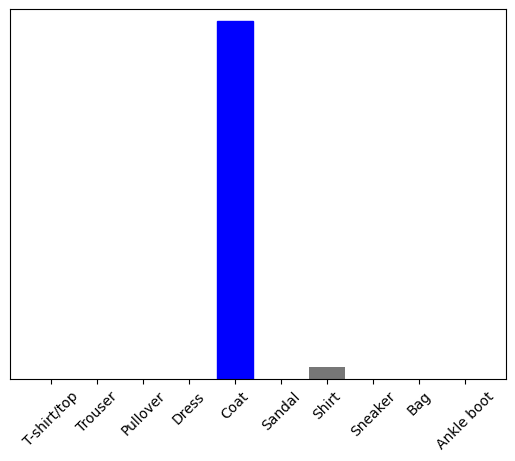

In [ ]:
plot_value_array(0, predictions_single, label_single)
_ = plt.xticks(range(10), class_names, rotation=45)

`keras.Model.predict` renvoie une liste de listes, une liste pour chaque image du lot de données. Saisissez les prédictions pour notre (seule) image dans le lot :

In [ ]:
np.argmax(predictions_single[0])

np.int64(4)

Et le modèle prédit une étiquette 4 (Coat) comme attendu.